## 讀取各年份合併後資料
https://dep.mohw.gov.tw/DOS/cp-2519-3480-113.html

## 死因統計(136分類)-縣市五齡.zip

In [1]:
import pandas as pd
df = pd.read_csv('./dataset/死因統計_136分類_100-110_大分類.csv', dtype = {'county': 'str'})
df.rename(columns = {'cuase_main_category':'cause_main_category'}, inplace = True)
df.drop(['Unnamed: 0'], axis = 1, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330683 entries, 0 to 330682
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   year                 330683 non-null  int64 
 1   county               330683 non-null  object
 2   cause                330683 non-null  int64 
 3   cause_main_category  330683 non-null  object
 4   sex                  330683 non-null  int64 
 5   age_code             330683 non-null  int64 
 6   N                    330683 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 17.7+ MB


In [ ]:
########################################################
## https://www.ndc.gov.tw/Content_List.aspx?n=32630C8F2494504D
##縣市代碼轉換為 北中南東離島
# 北部區域：包括臺北市、新北市、基隆市、新竹市、桃園市、新竹縣及宜蘭縣。
# #01、31、11、12、32、33、34

# 中部區域：包括臺中市、苗栗縣、彰化縣、南投縣及雲林縣。
# #03 35 37 38 39

# 南部區域：包括高雄市、臺南市、嘉義市、嘉義縣、屏東縣及澎湖縣。
# #07 05 22 40  43 44

# 東部區域：包括花蓮縣及臺東縣。
# #45 46

# 福建省：包括金門縣與連江縣。
# #90 91

## 110年 資料預前處理，準備測試新資料

In [2]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.preprocessing import StandardScaler

df_110 = df[df['year'] == 110]
country_area = {
'01':'north','31':'north','11':'north','12':'north','32':'north','33':'north','34':'north',
'03':'middle','35':'middle','37':'middle','38':'middle', '39':'middle',
'07':'south', '05':'south', '22':'south', '40':'south',  '43':'south', '44':'south',
'45':'east','46':'east','90':'Fujian','91':'Fujian'   
}
df_110['county'] = df_110['county'].map(country_area)
print(df_110['county'].value_counts())
##====================================================================
#條件篩選
#保留腫瘤疾病，移除'症狀、徵候與他處未歸類之異常臨床及實驗室發現', '妊娠(懷孕)、生產及產褥期', '源於周產期的特定病況', '先天性畸形、變形及染色體異常'
cause_select = ['症狀、徵候與他處未歸類之異常臨床及實驗室發現', '妊娠(懷孕)、生產及產褥期'
                , '源於周產期的特定病況', '先天性畸形、變形及染色體異常', '嚴重特殊傳染性肺炎（COVID-19）']
df_110 = df_110[~df_110['cause_main_category'].isin(cause_select)]
#====================================================================
# label encoding
le = LabelEncoder()
y_110 = df_110['cause_main_category']
y_110 = le.fit_transform(y_110)
#print(len(y))
cause_chinese_110 = pd.DataFrame(le.inverse_transform(y_110))
#print(len(y))
#====================================================================
#See the DataFrame
df_110.drop(columns=['cause_main_category', 'cause'], inplace = True, axis = 1)
print('年齡編碼轉換前',np.unique(df_110['age_code']))
df_110['age_code'] = le.fit_transform(df_110['age_code'])
df_110['cause_main_category'] = y_110
print('年齡編碼轉換後',np.unique(le.fit_transform(df_110['age_code'])))
#====================================================================
#dummy
df_110 = pd.get_dummies(df_110, columns =['sex', 'county'] )
#====================================================================
df_110
print(len(df_110['cause_main_category'].value_counts()))
#====================================================================
scaler = StandardScaler()
y_test_110 = df_110['cause_main_category']
df_110.drop(columns=['cause_main_category'], inplace = True, axis = 1)
df_110_test = scaler.fit_transform(df_110)

print(len(df_110_test))
print(len(y_test_110))

north     11179
south      8818
middle     8056
east       2109
Fujian      530
Name: county, dtype: int64
年齡編碼轉換前 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]
年齡編碼轉換後 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
15
29391
29391


C:\Users\USER\AppData\Local\Temp\ipykernel_2476\2410755021.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_110['county'] = df_110['county'].map(country_area)
C:\Users\USER\AppData\Local\Temp\ipykernel_2476\2410755021.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_110.drop(columns=['cause_main_category', 'cause'], inplace = True, axis = 1)
C:\Users\USER\AppData\Local\Temp\ipykernel_2476\2410755021.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [3]:
%%time
from imblearn.combine import SMOTEENN
sme = SMOTEENN(random_state=42)
df_110_test, y_test_110 = sme.fit_resample(df_110_test, y_test_110)
print(len(df_110_test))

25967
CPU times: total: 15.6 s
Wall time: 15.7 s


In [4]:
cause_code = pd.DataFrame(y_110)
df_main_cause = pd.concat([cause_chinese_110,cause_code],axis =1).drop_duplicates()
df_main_cause.columns = ['cause', 'cause_code']
df_main_cause.sort_values(['cause_code'],ascending=True, inplace = True)
df_main_cause.reset_index(drop=True, inplace= True)
df_main_cause

,cause,cause_code
0,內分泌、營養及新陳代謝疾病,0
1,呼吸系統疾病,1
2,導致罹病或致死之外因,2
3,循環系統疾病,3
4,泌尿生殖系統疾病,4
5,消化系統疾病,5
6,特定感染症及寄生蟲疾病,6
7,皮膚及皮下組織疾病,7
8,眼睛和附屬器官的疾病,8
9,神經系統疾病,9


##  100 ~ 109年 準備訓練資料

In [5]:
##排除110年
df = df[df['year'] != 110]

In [6]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
##====================================================================
#https://www.ndc.gov.tw/Content_List.aspx?n=32630C8F2494504D
#國發會
country_area = {
'01':'north','31':'north','11':'north','12':'north','32':'north','33':'north','34':'north',
'03':'middle','35':'middle','37':'middle','38':'middle','39':'middle',
'07':'south', '05':'south', '22':'south', '40':'south',  '43':'south', '44':'south',
'45':'east','46':'east','90':'Fujian','91':'Fujian'   
}
df['county'] = df['county'].map(country_area)
##====================================================================
#條件篩選
#保留腫瘤疾病，移除'症狀、徵候與他處未歸類之異常臨床及實驗室發現', '妊娠(懷孕)、生產及產褥期', '源於周產期的特定病況', '先天性畸形、變形及染色體異常'
cause_select = ['症狀、徵候與他處未歸類之異常臨床及實驗室發現', '妊娠(懷孕)、生產及產褥期'
                , '源於周產期的特定病況', '先天性畸形、變形及染色體異常', '嚴重特殊傳染性肺炎（COVID-19）']
df= df[~df['cause_main_category'].isin(cause_select)]
#====================================================================
#====================================================================
# label encoding
# y features
le = LabelEncoder()
y = df['cause_main_category']
y = le.fit_transform(y)
cause_chinese = pd.DataFrame(le.inverse_transform(y))  ##疾病轉換還原
#====================================================================
#X features
#See the DataFrame
print('年齡編碼轉換前',np.unique(df['age_code']))
df['age_code'] = le.fit_transform(df['age_code'])
print('年齡編碼轉換後',np.unique(le.fit_transform(df['age_code'])))
#====================================================
#X features
#dummy
df = pd.get_dummies(df, columns =['sex', 'county'] )
#====================================================
X = df
df.drop(columns=['cause', 'cause_main_category'], inplace = True, axis = 1)

年齡編碼轉換前 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]
年齡編碼轉換後 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]


## 訓練資料檢視

In [7]:
X.head()

,year,age_code,N,sex_1,sex_2,county_Fujian,county_east,county_middle,county_north,county_south
0,100,17,1,1,0,0,0,0,1,0
1,100,20,2,1,0,0,0,0,1,0
2,100,21,1,1,0,0,0,0,1,0
3,100,21,3,0,1,0,0,0,1,0
4,100,22,1,0,1,0,0,0,1,0


## 訓練資料-特徵縮放 StandardScaler (平均值和標準差)

In [8]:
%%time
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
print(len(X))
print(len(y))

288696
288696
CPU times: total: 93.8 ms
Wall time: 78.8 ms


## 訓練資料 SMOTE + ENN

In [9]:
%%time
#imbalanced Data 不平衡資料
#X, y 資料預處理已完成
from imblearn.combine import SMOTEENN
sme = SMOTEENN(random_state=42)
X, y = sme.fit_resample(X, y)
print(len(X))

266941
CPU times: total: 11min 21s
Wall time: 11min 24s


## 建立模型並預測新資料(110年)

In [12]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
rfc = RandomForestClassifier(n_estimators = 400 , oob_score=True, n_jobs= -1)                        
                             
rfc.fit(X , y)
#rfc.fit(X, y)
rfc_predict = rfc.predict(df_110_test) ##預測110年新資料
print('RandomForestClassifier model accuracy score: {0:0.4f}'. format(accuracy_score(y_test_110, rfc_predict)))
print(classification_report(rfc_predict,y_test_110))
#RandomForestClassifier model accuracy score: 0.4382  97 ~ 109

RandomForestClassifier model accuracy score: 0.4604
              precision    recall  f1-score   support

           0       0.59      0.47      0.52      1256
           1       0.52      0.58      0.55       591
           2       0.72      0.78      0.75       459
           3       0.00      0.03      0.01        38
           4       0.06      0.10      0.08       102
           5       0.26      0.49      0.33       101
           6       0.03      0.04      0.04       150
           7       0.48      0.35      0.40      2046
           8       0.18      0.73      0.29      1994
           9       0.38      0.24      0.30       501
          10       0.32      0.26      0.28      1350
          11       0.89      0.52      0.65     14153
          12       0.03      0.43      0.05       131
          13       0.18      0.11      0.13      1332
          14       0.36      0.26      0.30      1763

    accuracy                           0.46     25967
   macro avg       0.33     

In [ ]:
## 產製模型衡量報告
print(classification_report(rfc_predict,y_test_100))

## 隨機森林 - 衡量變數的重要程度

In [13]:
importances = rfc.feature_importances_
print(importances)
# Sort the feature importance in descending order
sorted_indices = np.argsort(importances)[::-1]

[0.2591363  0.36940645 0.27867509 0.01430737 0.01422203 0.00383422
 0.01151143 0.01514816 0.01598885 0.0177701 ]


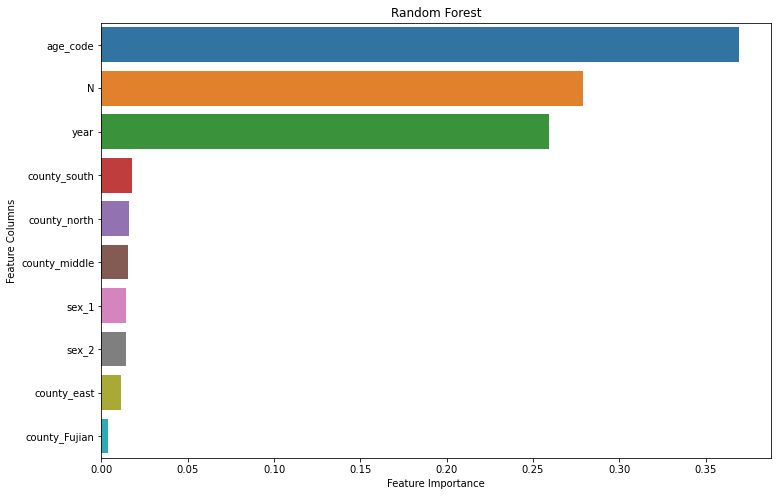

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_feature_importance(importance,names,model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    plt.figure(figsize=(12,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type)
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Columns')
importances = rfc.feature_importances_  ## The values of this array sum to 1
plot_feature_importance(importances,df.columns,'Random Forest')